In [1]:
import sys
sys.path.append('models/')
sys.path.append('eval/')

import glob
import itertools
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import pickle as pkl
import torch

from class_mve_loss import T_MVELoss
from default_parameters import *
import util_eval
import util_gcnn
import util_plot
from setup import *

%load_ext autoreload
%autoreload 2
plt.rcParams.update({'font.size': 10})

# Hyperparameters

In [2]:
out_folder = "2104_rc_new1/"

criterion = T_MVELoss()
max_lookback = 6
time_size = 4
predict_hzn = 1
train_extent = "downtown"
difference = True
device = torch.device("cpu")
n_time = 96//time_size - 7
include_spatial = False

# 95% pct
z=1.96

adj_type = ["func","euc","con","net"]
lookback = 2

In [3]:
# Get Data
data, adj, spatial, downtown_filter = \
    util_gcnn.combine_datasources(project_dir, 'after', predict_hzn, time_size, difference, max_lookback, lookback)

(num_train, _, _, n_modes) = data['x'][0].shape
(num_test, _, _, _) = data['x'][1].shape
n_stations = np.sum(downtown_filter)

ts_test = data['ts'][1]

max_station = np.argmax(np.mean(data['y'][1][:,:,downtown_filter], axis=0))
min_station = np.argmin(np.mean(data['y'][1][:,:,downtown_filter], axis=0))


## Models

In [4]:
def load_and_run(ii, model_period):
    
    # Turn Data into Torch Tensors
    _, _, valloader, testloader, adj_torch, spatial_torch, y_train_eval, y_val_eval, y_test_eval = \
                util_gcnn.prepare_for_torch(device, train_extent, data, adj, spatial, 
                                            downtown_filter, adj_type)    
    if not include_spatial:
        spatial_torch=None
    
    # Load Trained NN
    net = util_gcnn.load_model(project_dir, out_folder, 
                               model_period, train_extent, adj_type, predict_hzn, time_size, lookback, ii, 
                               n_modes, n_stations, n_time)

    # Run Data Through Selected Network
    output_mean, output_var, _ = util_gcnn.testset_output_gcn(testloader, False, False, net, criterion, adj_torch, 
                                    spatial_torch, device, n_time, return_components=False)

    return output_mean, output_var

In [5]:
# model period = before
# data period = after
a_ts_test, a_y_test_eval, ba_test_ens_mean, ba_test_ens_std, ba_ens_mean_list, ba_ens_std_list = \
    util_gcnn.ensemble(project_dir, out_folder, 'before', predict_hzn, time_size, lookback, 
                       b_ensemble_model_numbers, device, train_extent, adj_type, z,
                       data, adj, spatial, downtown_filter)

# model period = data period = after
_, _, aa_test_ens_mean, aa_test_ens_std, aa_ens_mean_list, aa_ens_std_list = \
    util_gcnn.ensemble(project_dir, out_folder, 'after', predict_hzn, time_size, lookback, 
                       a_ensemble_model_numbers, device, train_extent, adj_type, z,
                       data, adj, spatial, downtown_filter)

# model period = before
# data period = after
# single model
ba_test_mean, ba_test_std = load_and_run(b_ensemble_model_numbers[0], 'before')


## Evaluation

In [6]:
res = {}

In [7]:
print("Same Period Ensemble\n")
res['aa_ens_nll_loss'] = util_eval.eval_nll(criterion, aa_test_ens_mean, aa_test_ens_std, a_y_test_eval, stdout=True)
print()
res['aa_ens_mae'], res['aa_ens_mse'], _, _, _ = util_eval.eval_mean(aa_test_ens_mean, a_y_test_eval, 'Test', stdout=True)
res['aa_ens_rmse'] = np.sqrt(res['aa_ens_mse'])
print()
res['aa_ens_u'], res['aa_ens_um'], res['aa_ens_us'], res['aa_ens_uc'] = util_eval.eval_theils(np.squeeze(aa_test_ens_mean), a_y_test_eval, stdout=True)
print()
res['aa_ens_mpiw'], res['aa_ens_picp'] = util_eval.eval_pi(aa_test_ens_mean - z*aa_test_ens_std, aa_test_ens_mean + z*aa_test_ens_std, a_y_test_eval, stdout=True)


Same Period Ensemble

NLL: 70.444676

(Test) Mean Absolute Error: 13.463
(Test) Mean Squared Error: 654.492
Percent Nonzeros: 99%
Nonzero Entries:
(Test) Mean Absolute Error: 13.482
(Test) Mean Squared Error: 656.406

Theil's U: 0.075432
Bias: 0.000445
Variance: 0.014252
Covariance: 0.985303

MPIW: 80.892095
PICP: 0.961587


In [8]:
print("Different Period Ensemble\n")
res['ba_ens_nll_loss'] = util_eval.eval_nll(criterion, ba_test_ens_mean, ba_test_ens_std, a_y_test_eval, stdout=True)
print()
res['ba_ens_mae'], res['ba_ens_mse'], _, _, _ = util_eval.eval_mean(ba_test_ens_mean, a_y_test_eval, 'Test', stdout=True)
res['ba_ens_rmse'] = np.sqrt(res['ba_ens_mse'])
print()
res['ba_ens_u'], res['ba_ens_um'], res['ba_ens_us'], res['ba_ens_uc'] = util_eval.eval_theils(np.squeeze(ba_test_ens_mean), a_y_test_eval, stdout=True)
print()
res['ba_ens_mpiw'], res['ba_ens_picp'] = util_eval.eval_pi(ba_test_ens_mean - z*ba_test_ens_std, ba_test_ens_mean + z*ba_test_ens_std, a_y_test_eval, stdout=True)


Different Period Ensemble

NLL: 72.647651

(Test) Mean Absolute Error: 14.124
(Test) Mean Squared Error: 654.052
Percent Nonzeros: 99%
Nonzero Entries:
(Test) Mean Absolute Error: 14.151
(Test) Mean Squared Error: 656.054

Theil's U: 0.074013
Bias: 0.036631
Variance: 0.004673
Covariance: 0.958696

MPIW: 94.993493
PICP: 0.989524


In [9]:
print("Different Period Model\n")
res['ba_nll_loss'] = util_eval.eval_nll(criterion, ba_test_mean, ba_test_std, a_y_test_eval, stdout=True)
print()
res['ba_mae'], res['ba_mse'], _, _, _ = util_eval.eval_mean(ba_test_mean, a_y_test_eval, 'Test', stdout=True)
res['ba_rmse'] = np.sqrt(res['ba_mse'])
print()
res['ba_u'], res['ba_um'], res['ba_us'], res['ba_uc'] = util_eval.eval_theils(np.squeeze(ba_test_mean), a_y_test_eval, stdout=True)
print()
res['ba_mpiw'], res['ba_picp'] = util_eval.eval_pi(ba_test_mean - z*ba_test_std, ba_test_mean + z*ba_test_std, a_y_test_eval, stdout=True)


Different Period Model

NLL: 72.214459

(Test) Mean Absolute Error: 14.041
(Test) Mean Squared Error: 645.911
Percent Nonzeros: 99%
Nonzero Entries:
(Test) Mean Absolute Error: 14.064
(Test) Mean Squared Error: 647.803

Theil's U: 0.073775
Bias: 0.022969
Variance: 0.002118
Covariance: 0.974912

MPIW: 92.489664
PICP: 0.984762


## Add generalizability of WLS

In [10]:
# model period: before
period = 'before'
differenced='diff'
lookback = 2
z = 1.96

dates = pd.read_csv(project_dir+"data/"+period+"_dates.csv")
with open(project_dir+"data/data_processed/rail_catchment/"+period+"/"+
          period+"_"+str(predict_hzn)+"_"+str(time_size)+"_"+differenced+"_data_train.pkl","rb") as f:
    x_train = pkl.load(f)
    ref_train = pkl.load(f)
    los_train = pkl.load(f)
    weather_train = pkl.load(f)
    y_train = pkl.load(f)
    ts_train = pkl.load(f)
    station_id = pkl.load(f)
    

with open(project_dir+"data/data_processed/common_stations.pkl", "rb") as f:
    common_stations = pkl.load(f)
stations_mask = np.isin(np.array(station_id), common_stations)

x_train = x_train[:, :, stations_mask,:]
y_train = y_train[:, -1, stations_mask]
ref_train = ref_train[:, -1, stations_mask]
los_train = los_train[:,-1,stations_mask]

downtown_stations = pd.read_csv(project_dir+"data/data_processed/downtown_stations.csv")
downtown_filter = np.isin(np.array(station_id)[stations_mask], downtown_stations['STATION_ID'])

spatial = pd.read_csv(project_dir+"data/data_processed/rail_catchment/spatial.csv")

#print("All Available Columns:\n", spatial.columns.tolist())

spatial['pct_adults'] = spatial['pct25_34yrs']+spatial['pct35_50yrs']
spatial = spatial[['STATION_ID','tot_population','pct_adults','pctover65yrs',
         'pctPTcommute','avg_tt_to_work','inc_per_capita',
         'entertainment', 'restaurant', 'school', 'shop']]

#print("\n\nColumns included:\n", spatial.columns.tolist())
spatial = spatial.to_numpy()

# update station selections
common_stations = np.intersect1d(common_stations, spatial[:,0])

stations_mask = np.isin(spatial[:,0], common_stations)
spatial = spatial[stations_mask,1:]
# normalize the values that are not percentages
for i in [0,4,5,6,7,8,9]:
    spatial[:,i] = (spatial[:,i] - np.mean(spatial[:,i]))/np.std(spatial[:,i])

In [11]:
x_test = data['x'][-1]
y_test = np.squeeze(data['y'][-1])
weather_test = data['weather'][-1]
ref_test = np.squeeze(data['ref'][-1])
los_test = np.squeeze(data['los'][-1])

In [12]:
from util_wls import WLS 
n_station = np.sum(downtown_filter)
ols_x_train = np.moveaxis(x_train[:,max_lookback-lookback:,downtown_filter,:], 2, 1)
ols_x_test = np.moveaxis(x_test[:,:,downtown_filter,:], 2, 1)
ols_weather_train = np.tile(weather_train[:,np.newaxis,:], (1,n_station,1))
ols_weather_test = np.tile(weather_test[:,np.newaxis,:], (1,n_station,1))
spatial_train = np.tile(spatial[np.newaxis,downtown_filter,:], (len(ols_x_train),1,1))
spatial_test = np.tile(spatial[np.newaxis,downtown_filter,:], (len(ols_x_test),1,1))

ols_pred_test, ols_pred_std_test, wls_results = WLS(ols_x_train, ols_x_test, 
    [ref_train[:, downtown_filter], los_train[:, downtown_filter], spatial_train, ols_weather_train], 
    [ref_test[:, downtown_filter], los_test[:, downtown_filter], spatial_test, ols_weather_test], 
    y_train[:, downtown_filter], y_test[:, downtown_filter],
    model='5', extent='downtown', lookback=lookback, z=z, project_dir=project_dir, stdout=False);

Sample Size (Train): 56448
Number of Variables: 21



In [13]:
res['wls_mae'], res['wls_mse'], res['wls_u'], res['wls_um'], res['wls_us'], res['wls_uc'], res['wls_mpiw'], res['wls_picp'] = wls_results
res['wls_rmse'] = np.sqrt(res['wls_mse'])


## Table

In [14]:
metric_format = {'mae':'{0:.4}','rmse':'{0:.4}','u':'{0:.4}','um':'{0:.4}','us':'{0:.4}','uc':'{0:.4}',
                 'nll_loss':'{0:.4}','picp':'{0:.4}','mpiw':'{0:.4}'}
model_period = {'ba_ens': 'Before', 'aa_ens': 'During', 'ba': 'Before', 'wls':'Before'}
model_name = {'ba_ens': 'Ensemble', 'aa_ens': 'Ensemble', 'ba': 'Single', 'wls':'WLS'}

for mo in ['aa_ens','ba_ens','ba','wls']:
    print(model_period[mo], end=' & During & ')
    print(model_name[mo], end=' & ')
    for me in ['nll_loss','mpiw','picp','mae','rmse','u','um','us','uc']:
        end = ' & '
        if mo+'_'+me in res.keys():
            if me == 'uc':
                end='\\\\\n'
            if me in ['um','us']:
                end = ' / '
            if me == 'nll_loss':
                print(metric_format[me].format(-res[mo+'_'+me]), end=end)
            else:
                print(metric_format[me].format(res[mo+'_'+me]), end=end)
        else:
            print('', end=end)


During & During & Ensemble & -70.44 & 80.89 & 0.9616 & 13.46 & 25.58 & 0.07543 & 0.0004447 / 0.01425 / 0.9853\\
Before & During & Ensemble & -72.65 & 94.99 & 0.9895 & 14.12 & 25.57 & 0.07401 & 0.03663 / 0.004673 / 0.9587\\
Before & During & Single & -72.21 & 92.49 & 0.9848 & 14.04 & 25.41 & 0.07377 & 0.02297 / 0.002118 / 0.9749\\
Before & During & WLS &  & 120.8 & 0.873 & 34.85 & 54.87 & 0.1526 & 0.044 / 0.06648 / 0.8895\\


## Visualization

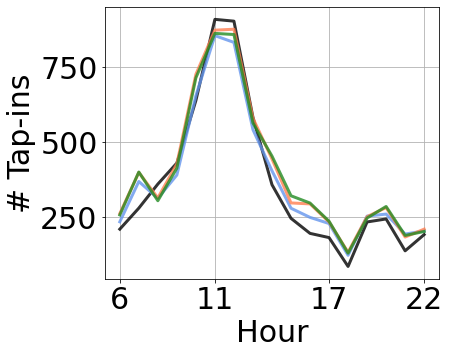

In [15]:
fig, ax = util_plot.plot_time_series(a_ts_test, [[a_y_test_eval[:,max_station]]], 
                               label1=['Ridership'], label2=['Actual'], 
                               colors=['black'], linewidth=3)

util_plot.plot_time_series(a_ts_test, 
                           [[aa_test_ens_mean[:, max_station], ba_test_ens_mean[:, max_station], ba_test_mean[:, max_station]]], 
                           label1=["# Tap-ins"], label2=['Same Period Ensemble','Different Period Ensemble','Different Period Model'], 
                           axes=ax, colors=['cornflowerblue','coral','forestgreen'], linewidth=3)
fig[0].savefig(project_dir+"figures/"+out_folder+"/rotest_max_mean.png", bbox_inches='tight')

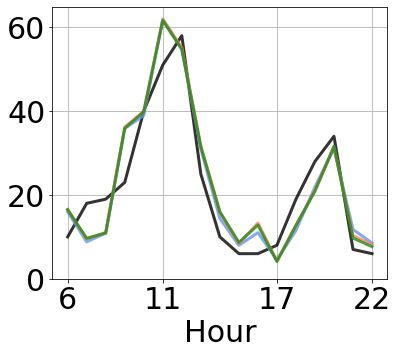

In [24]:
fig, ax = util_plot.plot_time_series(a_ts_test, [[a_y_test_eval[:,min_station]]], 
                               label1=['Ridership'], label2=['Actual'], 
                               colors=['black'], linewidth=3)

util_plot.plot_time_series(a_ts_test, 
                           [[aa_test_ens_mean[:, min_station], ba_test_ens_mean[:, min_station], ba_test_mean[:, min_station]]], 
                           label1=None, label2=['Same Period Ensemble','Different Period Ensemble','Different Period Model'], 
                           axes=ax, colors=['cornflowerblue','coral','forestgreen'], linewidth=3)
ax[0].set_ylim([0,ax[0].get_ylim()[1]])
fig[0].savefig(project_dir+"figures/"+out_folder+"/rotest_min_mean.png", bbox_inches='tight')

Plotting cell with max flow:  (5,)


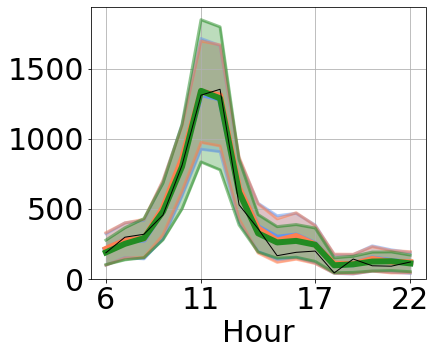

In [26]:
fig, ax = util_plot.plot_pi_graph(ts_test=ts_test, y_test=a_y_test_eval, 
                              pred_test=[ba_test_mean,ba_test_ens_mean,aa_test_ens_mean], 
                              pred_std=[ba_test_std,ba_test_ens_std,aa_test_ens_std],
                              z=z, time_size=time_size,                               
                              models=['Different Period Model','Different Period Ensemble','Same Period Ensemble'],
                              linewidth=3)
ax.set_ylim([0,ax.get_ylim()[1]])
fig.savefig(project_dir+"figures/"+out_folder+"/rotest_max_pi.png", bbox_inches='tight')

Plotting cell with min flow:  (2,)


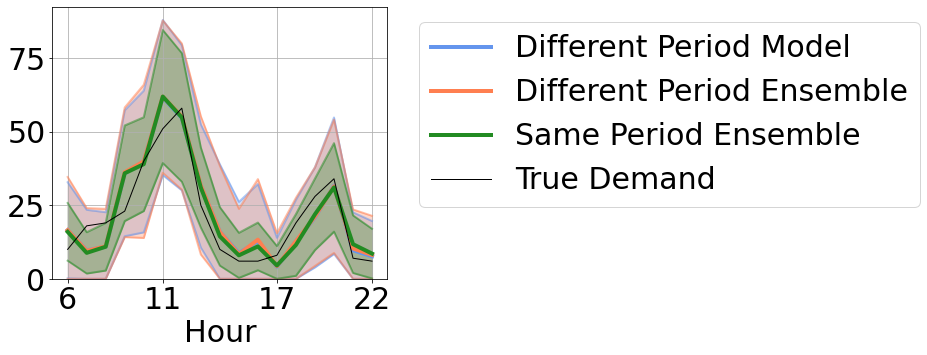

In [16]:
fig, ax = util_plot.plot_pi_graph(ts_test=ts_test, y_test=a_y_test_eval, 
                              pred_test=[ba_test_mean,ba_test_ens_mean,aa_test_ens_mean], 
                              pred_std=[ba_test_std,ba_test_ens_std,aa_test_ens_std],
                              z=z, time_size=time_size, 
                              models=['Different Period Model','Different Period Ensemble','Same Period Ensemble'],
                              plot_cell=-1, linewidth=2)
ax.set_ylim([0,ax.get_ylim()[1]])
ax.legend(bbox_to_anchor=(1.05, 1))
fig.savefig(project_dir+"figures/"+out_folder+"/rotest_min_pi.png", bbox_inches='tight')

## Test on Modified Input (not used)

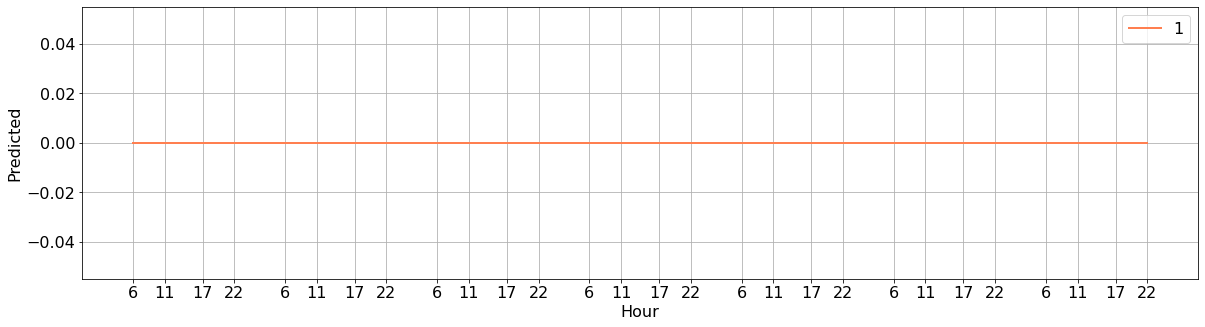

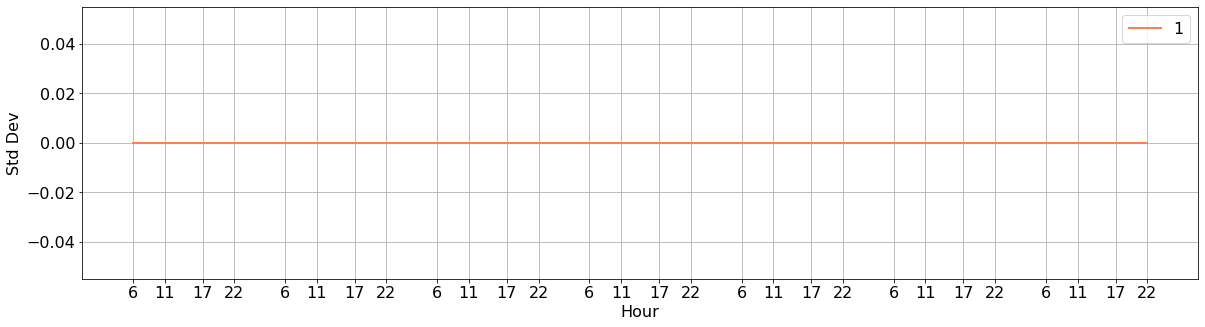

In [22]:
# Test modified data
ii = 103

factor = 1
data_copy = data.copy()
data_copy['x'][1] = data_copy['x'][1]*factor

output_mean_1, output_var_1 = load_and_run(ii, data_period)


factor = 1
data_copy = data.copy()
data_copy['x'][1] = data_copy['x'][1]*factor

output_mean, output_var = load_and_run(ii, data_period)


fig, ax = util_plot.plot_time_series(ts_test, [[output_mean[:,min_station]-output_mean_1[:,min_station]], 
                                               [output_var[:,min_station]-output_var_1[:,min_station]]], 
                                     label1=['Predicted', 'Std Dev'], label2=[factor], colors=['coral','coral'])


#fig[0].savefig(project_dir+"figures/"+out_folder+"/"+period+"_scenario_mean.png", bbox_inches='tight')
#fig[1].savefig(project_dir+"figures/"+out_folder+"/"+period+"_scenario_std.png", bbox_inches='tight')